In [1]:
import collections
import json
import math
import os
import re
import time

import ahocorasick
import networkx as nx
import openai
import pandas as pd
import pdfplumber
import torch
import transformers
from fuzzywuzzy import fuzz
from matplotlib import pyplot as plt

dataDir = "../data/"
dataName = "Deep Learning.pdf"
import codecs
import copy
import random

import numpy as np
from tqdm.notebook import tqdm
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline

# 设置 api


In [2]:
# openai.api_base = "https://api.chatanywhere.com.cn/"
openai.api_base = "https://api.chatanywhere.cn/"
openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"

# 一，读取数据


## 生成目录架构

- 生成**章节名称**与**章节序号**的对应：`name_dict`
- 以及**章节序号**与**章节页码**范围的对应：`index_dict`


In [3]:
with pdfplumber.open(dataDir + dataName) as f:
    # 目录架构生成
    c, p, n = [], [], []
    for i in range(7):
        page = f.pages[i]
        text = page.extract_text()
        text_split = text.split("\n")
        for i in text_split:
            if bool(re.match("[0-9]+\.[0-9]+", i.split(" ")[0])):
                c.append(i.split(" ")[0])
                p.append(int(i.split(" ")[-1]) + 15)
            if bool(re.match("[0-9]+", i.split(" ")[0])):
                for j in i.split(" "):
                    if bool(re.match("[A-Za-z]+", j)):
                        n.append((i.split(" ")[0], j))

### name_dict


In [4]:
name_dict = {}
for i, j in n:
    if i in name_dict:
        name_dict[i] = name_dict.get(i, "") + " " + j
    else:
        name_dict[i] = name_dict.get(i, "") + j

### index_dict


In [5]:
p_range = list(zip(p, p[1:]))
p_range.append((735, 800))
c_p_range = list(zip(c, p_range))
index_dict = collections.defaultdict(list)
for k, v in c_p_range:
    index_dict[k.split(".")[0]].append((k, v))

## 生成内容表

- 段落内容表：`content_dict`


### content_dict

In [6]:
with pdfplumber.open(dataDir + dataName) as f:
    content_dict = collections.defaultdict(list)

    for k, v in tqdm(index_dict.items(), total=len(index_dict)):
        for i in v:
            page_range = i[-1]
            if page_range[0] == page_range[1]:
                page_range = (page_range[0], page_range[1] + 1)
            for j in range(int(page_range[0]) - 1, int(page_range[1]) - 1):
                page = f.pages[j]

                text = page.extract_text().replace("\n", " ")

                content_dict[i[0]].append(text)

  0%|          | 0/20 [00:00<?, ?it/s]

# 二，抽取实体与关系

## GPT3.5

### 价格计算

In [7]:
def total_counts(response):
    tokens_nums = int(response["usage"]["total_tokens"])
    price = 0.003 / 1000
    cost = "{:.5f}".format(price * tokens_nums * 7.5)
    print(f"tokens: {tokens_nums}, cost: {cost}")

    return float(cost)

### 定义Chat

In [8]:
class Chat:
    def __init__(self, conversation_list=[]):
        self.conversation_list = conversation_list
        self.costs_list = []

    def show_conversation(self, msg_list):
        for msg in msg_list[-2:]:
            if msg["role"] == "user":
                pass
            else:
                message = msg["content"]
                pass
                # print(f"\U0001f47D: {message}\n")

    def ask(self, prompt):
        self.conversation_list.append({"role": "user", "content": prompt})
        openai.api_key = "sk-LzwgVgu5xvNPpwoqCdeeVcAt7Tu7ZoZICXzzkheldIbXA60h"
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-16k", messages=self.conversation_list
        )
        answer = response.choices[0].message["content"]

        self.conversation_list.append({"role": "assistant", "content": answer})
        self.show_conversation(self.conversation_list)

        # cost = total_counts(response)
        # self.costs_list.append(cost)
        return answer

### 设置prompt

In [9]:
NER_prompt = [
    "你是一个深度学习、机器学习、数学、计算机科学领域的实体标注专员，\
给定字符串，请找出全部深度学习、机器学习、数学、计算机科学领域的实体，\
以('entity1', 'entity2', ...)的格式返回，尽量遵循字符串中的原本表述。\
除返回结果外，不要返回任何其他内容。"
]

In [10]:
relations = "'based on', 'facet of', 'part of', 'instance of', 'subject of', 'subclass of', 'use'"

In [11]:
relation_prompt = [
    f"你是一个深度学习、机器学习、数学、计算机科学领域的关系抽取专员，\
给定关系列表({relations})，\
输入实体列表，请找出实体列表中存在关系的实体，\
并以('head', 'relation', 'tail')的格式返回所有三元组，\
请尽量不改变原实体的表述。\
除结果外，不要返回任何其他内容。\
如输入'LSTM, RNN'，返回('LSTM', 'instance of', 'RNN')"
]

In [12]:
judge_prompt = ['你是一个深度学习、机器学习、数学、计算机科学领域的实体判断专员，\
请判断给定实体是否属于这些领域，\
若属于返回True，不属于返回False。\
除结果外不要返回任何其他内容']

### 模拟断点续传

In [13]:
content_dict_2 = {}
str_temp = "20.15"
page_temp = 23
j = float("inf")
for i, (k, v) in enumerate(content_dict.items()):
    if k == str_temp:
        j = i
    if i >= j:
        content_dict_2[k] = v

### 抽取关系
注释以防止运行时再次抽取

In [14]:
# for k, v in content_dict_2.items():
#     for page, content in enumerate(v):
#         if (k==str_temp and page>page_temp) or k!=str_temp:
#             if page % 5 == 0:
#                 conversation_list = [
#                     {
#                         "role": "system",
#                         "content": NER_prompt[0],
#                     }
#                 ]
#                 bot_ner = Chat(conversation_list)
#                 conversation_list = [
#                     {
#                         "role": "system",
#                         "content": relation_prompt[0],
#                     }
#                 ]

#                 bot_relation = Chat(conversation_list)
#             answer_ner = bot_ner.ask(content)
#             answer_relation = bot_relation.ask(answer_ner)
#             df = pd.DataFrame(
#                 [[k, page, answer_ner, answer_relation]],
#                 columns=["section", "page", "entity", "relation"],
#             )
#             df.to_csv(
#                 os.path.join(dataDir + "/relations", f"results_gpt3_5.csv"),
#                 mode="a",
#                 header=not os.path.exists(
#                     os.path.join(dataDir + "/relations", f"results_gpt3_5.csv")
#                 ),
#                 index=False,
#             )

# 三，Build Relations

## 目录 + 前置

In [15]:
def catalogue_relations(dataName, name_dict=None, relation_type=["目录", "前置"]):
    c_relations = []
    p_relations = []
    if not name_dict:
        name_dict = {}
    for k, v in name_dict.items():
        if bool(re.match("[0-9]+\.[0-9]+", k)):
            p_relations.append(
                [
                    k.split(".")[0] + " " + name_dict[k.split(".")[0]],
                    relation_type[1],
                    k + " " + v,
                ]
            )
        else:
            c_relations.append(
                [
                    dataName,
                    relation_type[0],
                    k + " " + v,
                ]
            )
    return p_relations, c_relations

In [16]:
p_relations, c_relations = catalogue_relations(
    dataName=dataName.split(".")[0], name_dict=name_dict
)

## 包含 + 共现 + 位置

### 读取关系

In [17]:
df = pd.read_csv(
    dataDir + "relations/" + "results_gpt3_5.csv",
    index_col=False,
    dtype={"section": str, "page": int},
)

注释以防止运行时再次修复bug

In [18]:
# fix bugs

# df = pd.read_csv(
#     dataDir + "relations/" + "results_gpt3_5-Copy1.csv",
#     index_col=False,
#     dtype={"section": str, "page": int},
# )


# df["entity"] = df["entity"].shift(-14)
# df["relation"] = df["relation"].shift(-14)
# df = df.iloc[11:703, :]

# padding_dict = collections.defaultdict(list)
# for i, j in index_dict.items():
#     for page in j:
#         if page[1][0] == page[1][1]:
#             padding_dict["section"].append(page[0])
#             padding_dict["page"].append(0)
#             padding_dict["entity"].append(
#                 df[
#                     df["section"]
#                     == (
#                         page[0].split(".")[0]
#                         + "."
#                         + str(int(page[0].split(".")[1]) - 1)
#                     )
#                 ].iloc[-1]["entity"]
#             )
#             padding_dict["relation"].append(
#                 df[
#                     df["section"]
#                     == (
#                         page[0].split(".")[0]
#                         + "."
#                         + str(int(page[0].split(".")[1]) - 1)
#                     )
#                 ].iloc[-1]["relation"]
#             )
# padding_df = pd.DataFrame(padding_dict)

# df = df._append(padding_df, ignore_index=True)

# df.to_csv(
#     os.path.join(dataDir + "/relations", f"results_gpt3_5.csv"),
#     mode="w",
#     index=False,
# )

In [19]:
df["entity_list"] = df["entity"].apply(
    lambda x: re.sub("\(|\)|", "", x[2:-2]).split("', '")
)

In [20]:
df["relation_tuple"] = df["relation"].apply(
    lambda x: [re.findall(r"'(.*?)', '(.*?)', '(.*?)'", i) for i in x.split("\n")]
)

### 实体清理 

#### 基于规则

In [21]:
not_use_entity_set = {
    "matrix W",
    "sensor\\",
    "base distribution p(x)",
    "functions",
    "py|x",
    "ht",
    "α, β, β, f, φ, x, y, τ",
    "true θ",
    "All you need is a good init",
    "milestone",
    "px = x,y = y z = z",
    "class",
    "path",
    "Loop",
    "bytes",
    "Muja",
    "ICML’13' 'Goodfellow",
    "USA",
    "Caffe",
    "new drugs",
    "Amazon",
    "ph v",
    "update H 1g",
    "location",
    "house",
    "is less than",
    "Springer' 'Frasconi",
    "melody",
    "logp",
}
relations_set = {
    "based on",
    "facet of",
    "part of",
    "instance of",
    "subject of",
    "subclass of",
    "use",
    "used by",
    "method of",
    "measure of",
    " instance of",
    "algorithm for",
    "contains",
    "defined by",
    "includes",
    "is a",
}
pattern_list = [
    "(^([0-9]+|[A-Za-z])$)",  # 匹配纯数字或单个字母
    "(\\b[A-Z][a-z]*([-][A-Z][a-z]*)?,\s?[A-Z]([-][A-Z])?(\.[A-Z]?[-]?)*\.)",  # 匹配人名，如Rezende, D. J.和Wierstra, D.
    "(.*\(?\d{4}\)?)",  # 匹配以(年份)结尾的任意字符串
    "([A-Za-z]+\([A-Z]\))",  # 匹配p(x), f(x), sin(x)等
    "(.*\s\d+\.\d+)",  # 匹配algorithm 18.1
    "(([A-Z]+(?:\s|-)){1,}[A-Z]+)",  # 匹配章节名称，如NEGATIVE LOG-LIKELIHOOD
    "(.*\set\sal\..*)",  # 匹配 et al.
]
max_len = 35  # 限制长度
max_similarity = 90  # 限制相似度

In [22]:
c_entity_path = os.path.join(dataDir, "relations", "c_entity_set.json")
if os.path.exists(c_entity_path):
    with open(c_entity_path, "r") as f:
        temp_entity_set = set(json.load(f))
    c_entity_set = set()
    for entity in temp_entity_set:
        if (
            entity not in not_use_entity_set
            and not bool(re.match(("|".join(pattern_list)), entity))
            and 2 < len(entity) < max_len
        ):
            c_entity_set.add(entity)

else:
    c_entity_set = set()
    for idx in tqdm(df.index, total=len(df)):
        for entity in df["entity_list"][idx]:
            if (
                all(
                    pd.Series(list(c_entity_set)).apply(
                        lambda x: fuzz.partial_token_sort_ratio(x, entity)
                        <= max_similarity
                        or x == entity
                    )
                )
                and entity not in not_use_entity_set
                and not bool(re.match(("|".join(pattern_list)), entity))
                and 2 < len(entity) < max_len
            ):
                c_entity_set.add(entity)

with open(c_entity_path, "w") as f:
    json.dump(list(c_entity_set), f, indent=4)

In [23]:
print(f"after: {len(c_entity_set)}")

after: 2669


#### 基于词频

In [24]:
all_text = " ".join([" ".join(v) for k, v in content_dict.items()]).split(" ")
ng1 = collections.defaultdict(int)
ng2 = collections.defaultdict(int)
ng3 = collections.defaultdict(int)
ng4 = collections.defaultdict(int)
for i, j in enumerate(all_text):
    ng1[j] += 1
    if i > 0:
        ng2[(all_text[i - 1], j)] += 1
    if i > 1:
        ng3[(all_text[i - 2], all_text[i - 1], j)] += 1
    if i > 2:
        ng4[(all_text[i - 3], all_text[i - 2], all_text[i - 1], j)] += 1

In [25]:
def sort_feq(dic, reverse=True):
    return sorted([(k, v) for k, v in dic.items()], key=lambda x: x[1], reverse=reverse)

In [26]:
entity_dict_with_freq = {}
for entity in c_entity_set:
    ng_key = entity.split(" ")
    ng_len = len(ng_key)
    if ng_len == 1:
        entity_dict_with_freq[ng_key[0]] = ng1[ng_key[0]]
    elif ng_len == 2:
        entity_dict_with_freq[tuple(ng_key)] = ng2[tuple(ng_key)]
    elif ng_len == 3:
        entity_dict_with_freq[tuple(ng_key)] = ng3[tuple(ng_key)]
    elif ng_len == 4:
        entity_dict_with_freq[tuple(ng_key)] = ng4[tuple(ng_key)]
    else:
        entity_dict_with_freq[tuple(ng_key)] = 0

In [27]:
entity_dict_with_freq_filtered = dict(
    ((k, v) for k, v in entity_dict_with_freq.items() if v != 0)
)

In [28]:
temp_set = set()
for entity, _ in entity_dict_with_freq_filtered.items():
    if isinstance(entity, tuple):
        temp_set.add(" ".join(entity))
    else:
        temp_set.add(entity)
c_entity_set = temp_set.copy()

In [29]:
print(f"after: {len(c_entity_set)}")

after: 1975


#### 基于停用词

In [30]:
with open(dataDir + "stopwords.txt", "r") as f:
    stopwords = set()
    for line in f.readlines():
        stopwords.add(line.replace("\n", "").strip())
temp_set = c_entity_set.copy()
remove_list = []
for entity in temp_set:
    if entity in stopwords:
        remove_list.append(entity)
        c_entity_set.remove(entity)
print(f"entities need to be removed: {remove_list}")

entities need to be removed: ['groups', 'state', 'past', 'index', 'effect', 'face', 'ordering']


In [31]:
print(f"after: {len(c_entity_set)}")

after: 1968


#### 借助GPT3.5

In [32]:
temp_set = c_entity_set.copy()
temp_df = pd.read_csv(os.path.join(dataDir + "/relations", f"gpt_entity_judgement.csv"))
for i in c_entity_set:
    if i in set(temp_df['entity']):
        temp_set.remove(i)

In [33]:
len(temp_set)

556

注释以防止运行时再次判断

In [34]:
# gpt_judge = {}
# for i, j in tqdm(enumerate(temp_set), total=len(temp_set)):
#     if i % 5 == 0:
#         conversation_list = [
#             {
#                 "role": "system",
#                 "content": judge_prompt[0],
#             }
#         ]
#         bot_jud = Chat(conversation_list)
#     answer = bot_jud.ask(j)
#     gpt_judge[j] = answer
#     df_jud = pd.DataFrame(
#         [[j, answer]],
#         columns=["entity", "judgement"],
#     )
#     df_jud.to_csv(
#         os.path.join(dataDir + "/relations", f"gpt_entity_judgement.csv"),
#         mode="a",
#         header=not os.path.exists(
#             os.path.join(dataDir + "/relations", f"gpt_entity_judgement.csv")
#         ),
#         index=False,
#     )

In [35]:
gpt_judgement = pd.read_csv(os.path.join(dataDir + "/relations", f"gpt_entity_judgement.csv"))
len(gpt_judgement[gpt_judgement['judgement']!='False'])
c_entity_set = set(gpt_judgement[gpt_judgement['judgement']!='False']['entity']).union(temp_set)

In [36]:
print(f"after: {len(c_entity_set)}")

after: 1596


In [37]:
semantic_set = set()
entity_dict = collections.defaultdict(set)

for idx in df.index:
    for entity in df["entity_list"][idx]:
        if (
            entity in c_entity_set
            and entity not in not_use_entity_set
            and not bool(re.match(("|".join(pattern_list)), entity))
            and 2 < len(entity) < max_len
        ):
            entity_dict[df["section"][idx] + " " + str(df["page"][idx])].add(entity)
            c_entity_set.add(entity)
    for relations in df["relation_tuple"][idx]:
        for relation in relations:
            if len(relation) == 3:
                if (
                    relation[1] in relations_set
                    and relation[0] not in not_use_entity_set
                    and relation[0] in c_entity_set
                    and relation[2] not in not_use_entity_set
                    and relation[2] in c_entity_set
                    and not bool(re.match(("|".join(pattern_list)), relation[0]))
                    and 2 < len(relation[0]) < max_len
                    and not bool(re.match(("|".join(pattern_list)), relation[2]))
                    and 2 < len(relation[2]) < max_len
                    and relation[0] != relation[2]
                ):
                    semantic_set.add(tuple(i.strip() for i in relation))

### AC自动机

In [39]:
def build(patterns):
    trie = ahocorasick.Automaton()
    for index, word in enumerate(patterns):
        trie.add_word(word, (index, word))
    trie.make_automaton()
    return trie

In [53]:
patterns = [','.join(str(i) for i in [1,2,3])]
trie = build(patterns)
iter_ = trie.iter(','.join(str(i) for i in [2,3,4,5,6,1,2,3,4]))
for i in iter_:
    print(i)

(14, (0, '1,2,3'))


### 结构关系抽取

In [120]:
# def include_co_presence(entity_set):
#     patterns = list(entity_set)
#     trie = build(patterns)
#     include_relations = []
#     co_presence_relations = set()
#     for chapter, sections in index_dict.items():
#         for section in sections:
#             for content in content_dict[section[0]]:
#                 word_set = set(word[1][1] for word in trie.iter(content))
#                 for head in word_set:
#                     if not bool(re.match("^(\d+|[A-Za-z])$", head)):
#                         include_relations.append(
#                             [section[0] + " " + name_dict[section[0]], "include", head]
#                         )
#                         for tail in word_set:
#                             if head != tail and not bool(
#                                 re.match("^(\d+|[A-Za-z])$", tail)
#                             ):
#                                 if (
#                                     tail,
#                                     "co_presence",
#                                     head,
#                                 ) not in co_presence_relations:
#                                     co_presence_relations.add(
#                                         (head, "co_presence", tail)
#                                     )
#     return include_relations, co_presence_relations


def include_co_presence(entity_dict):
    include_relations = set()
    co_presence_relations = set()
    location_set = set()
    for section_page, entity_list in entity_dict.items():
        # 位置信息
        for section in index_dict[section_page.split(" ")[0].split(".")[0]]:
            if section[0] == section_page.split(" ")[0]:
                page = int(section[1][0])
        for entity in entity_list:
            location_set.add((page + int(section_page.split(" ")[1]), entity))

        # 包含关系
        for entity in entity_list:
            name = name_dict[section_page.split(" ")[0]]
            include_relations.add(
                (section_page.split(" ")[0] + " " + name, "include", entity)
            )

            # 共现关系
            for tail in entity_list:
                if entity != tail:
                    co_presence_relations.add((entity, "co_presence", tail))
    return include_relations, co_presence_relations, location_set

In [121]:
include_relations, co_presence_relations, location_set = include_co_presence(
    entity_dict
)

In [122]:
location_dict = collections.defaultdict(list)
for i in location_set:
    location_dict[i[-1]].append(i[:-1])

## 结果展示

### 语义

In [123]:
print(len(semantic_set), list(semantic_set)[1])

903 ('probability distribution', 'based on', 'binary variable')


### 前置

In [124]:
p_relations[0]

['1 Introduction', '前置', '1.1 Who Should Read This Book?']

### 目录

In [125]:
c_relations[0]

['Deep Learning', '目录', '1 Introduction']

### 共现

In [126]:
print(len(co_presence_relations), list(co_presence_relations)[0])

19578 ('testing', 'co_presence', 'images')


### 包含

In [127]:
print(len(include_relations), list(include_relations)[0])

2975 ('4.4 Constrained Optimization', 'include', 'generalized La- grange function')


In [136]:
test = pd.DataFrame(include_relations, columns=['head', 'relation', 'tail'])
test[test['head']=='8.5 Algorithms with Adaptive Learning Rates']

,head,relation,tail
276,8.5 Algorithms with Adaptive Learning Rates,include,unsupervised model
395,8.5 Algorithms with Adaptive Learning Rates,include,momentum algorithm
640,8.5 Algorithms with Adaptive Learning Rates,include,convergence
845,8.5 Algorithms with Adaptive Learning Rates,include,SGD
1041,8.5 Algorithms with Adaptive Learning Rates,include,AdaDelta
1081,8.5 Algorithms with Adaptive Learning Rates,include,Nesterov momentum
1839,8.5 Algorithms with Adaptive Learning Rates,include,supervised model
1957,8.5 Algorithms with Adaptive Learning Rates,include,delta-bar-delta algorithm
1983,8.5 Algorithms with Adaptive Learning Rates,include,RMSProp algorithm
2510,8.5 Algorithms with Adaptive Learning Rates,include,parameter space


### 位置

In [128]:
location_dict["LSTM"][0]

(434,)

In [129]:
structure_relations = (
    p_relations + c_relations + list(co_presence_relations) + list(include_relations)
)

In [130]:
len(structure_relations)

22737

# 三，储存数据

In [131]:
with open(os.path.join(dataDir + "/relations", f"semantic_relations.json"), "w") as f:
    json.dump(list(semantic_set), f, indent=4)

In [132]:
with open(os.path.join(dataDir + "/relations", f"structure_relations.json"), "w") as f:
    json.dump(structure_relations, f, indent=4)

In [133]:
with open(os.path.join(dataDir + "/relations", f"location.json"), "w") as f:
    json.dump(location_dict, f, indent=4)

# 四，测试

## 绘制图谱（仅测试用，非最终成品）

In [256]:
len(c_entity_set)

1969

In [257]:
test_set = set()
for i in include_relations:
    test_set.add(i[2])
len(test_set)

1969

### 整理数据

In [258]:
kg_df = pd.DataFrame(structure_relations, columns=["head", "relation", "tail"])

In [274]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(
    kg_df[
        (kg_df["relation"] == "前置")
        & (
            (kg_df["head"] == "20 Deep Generative Models")
            | (kg_df["head"] == "3 Probability and Information Theory")
        )
    ],
    "head",
    "tail",
    edge_attr=True,
    create_using=nx.MultiDiGraph(),
)

### 图谱测试

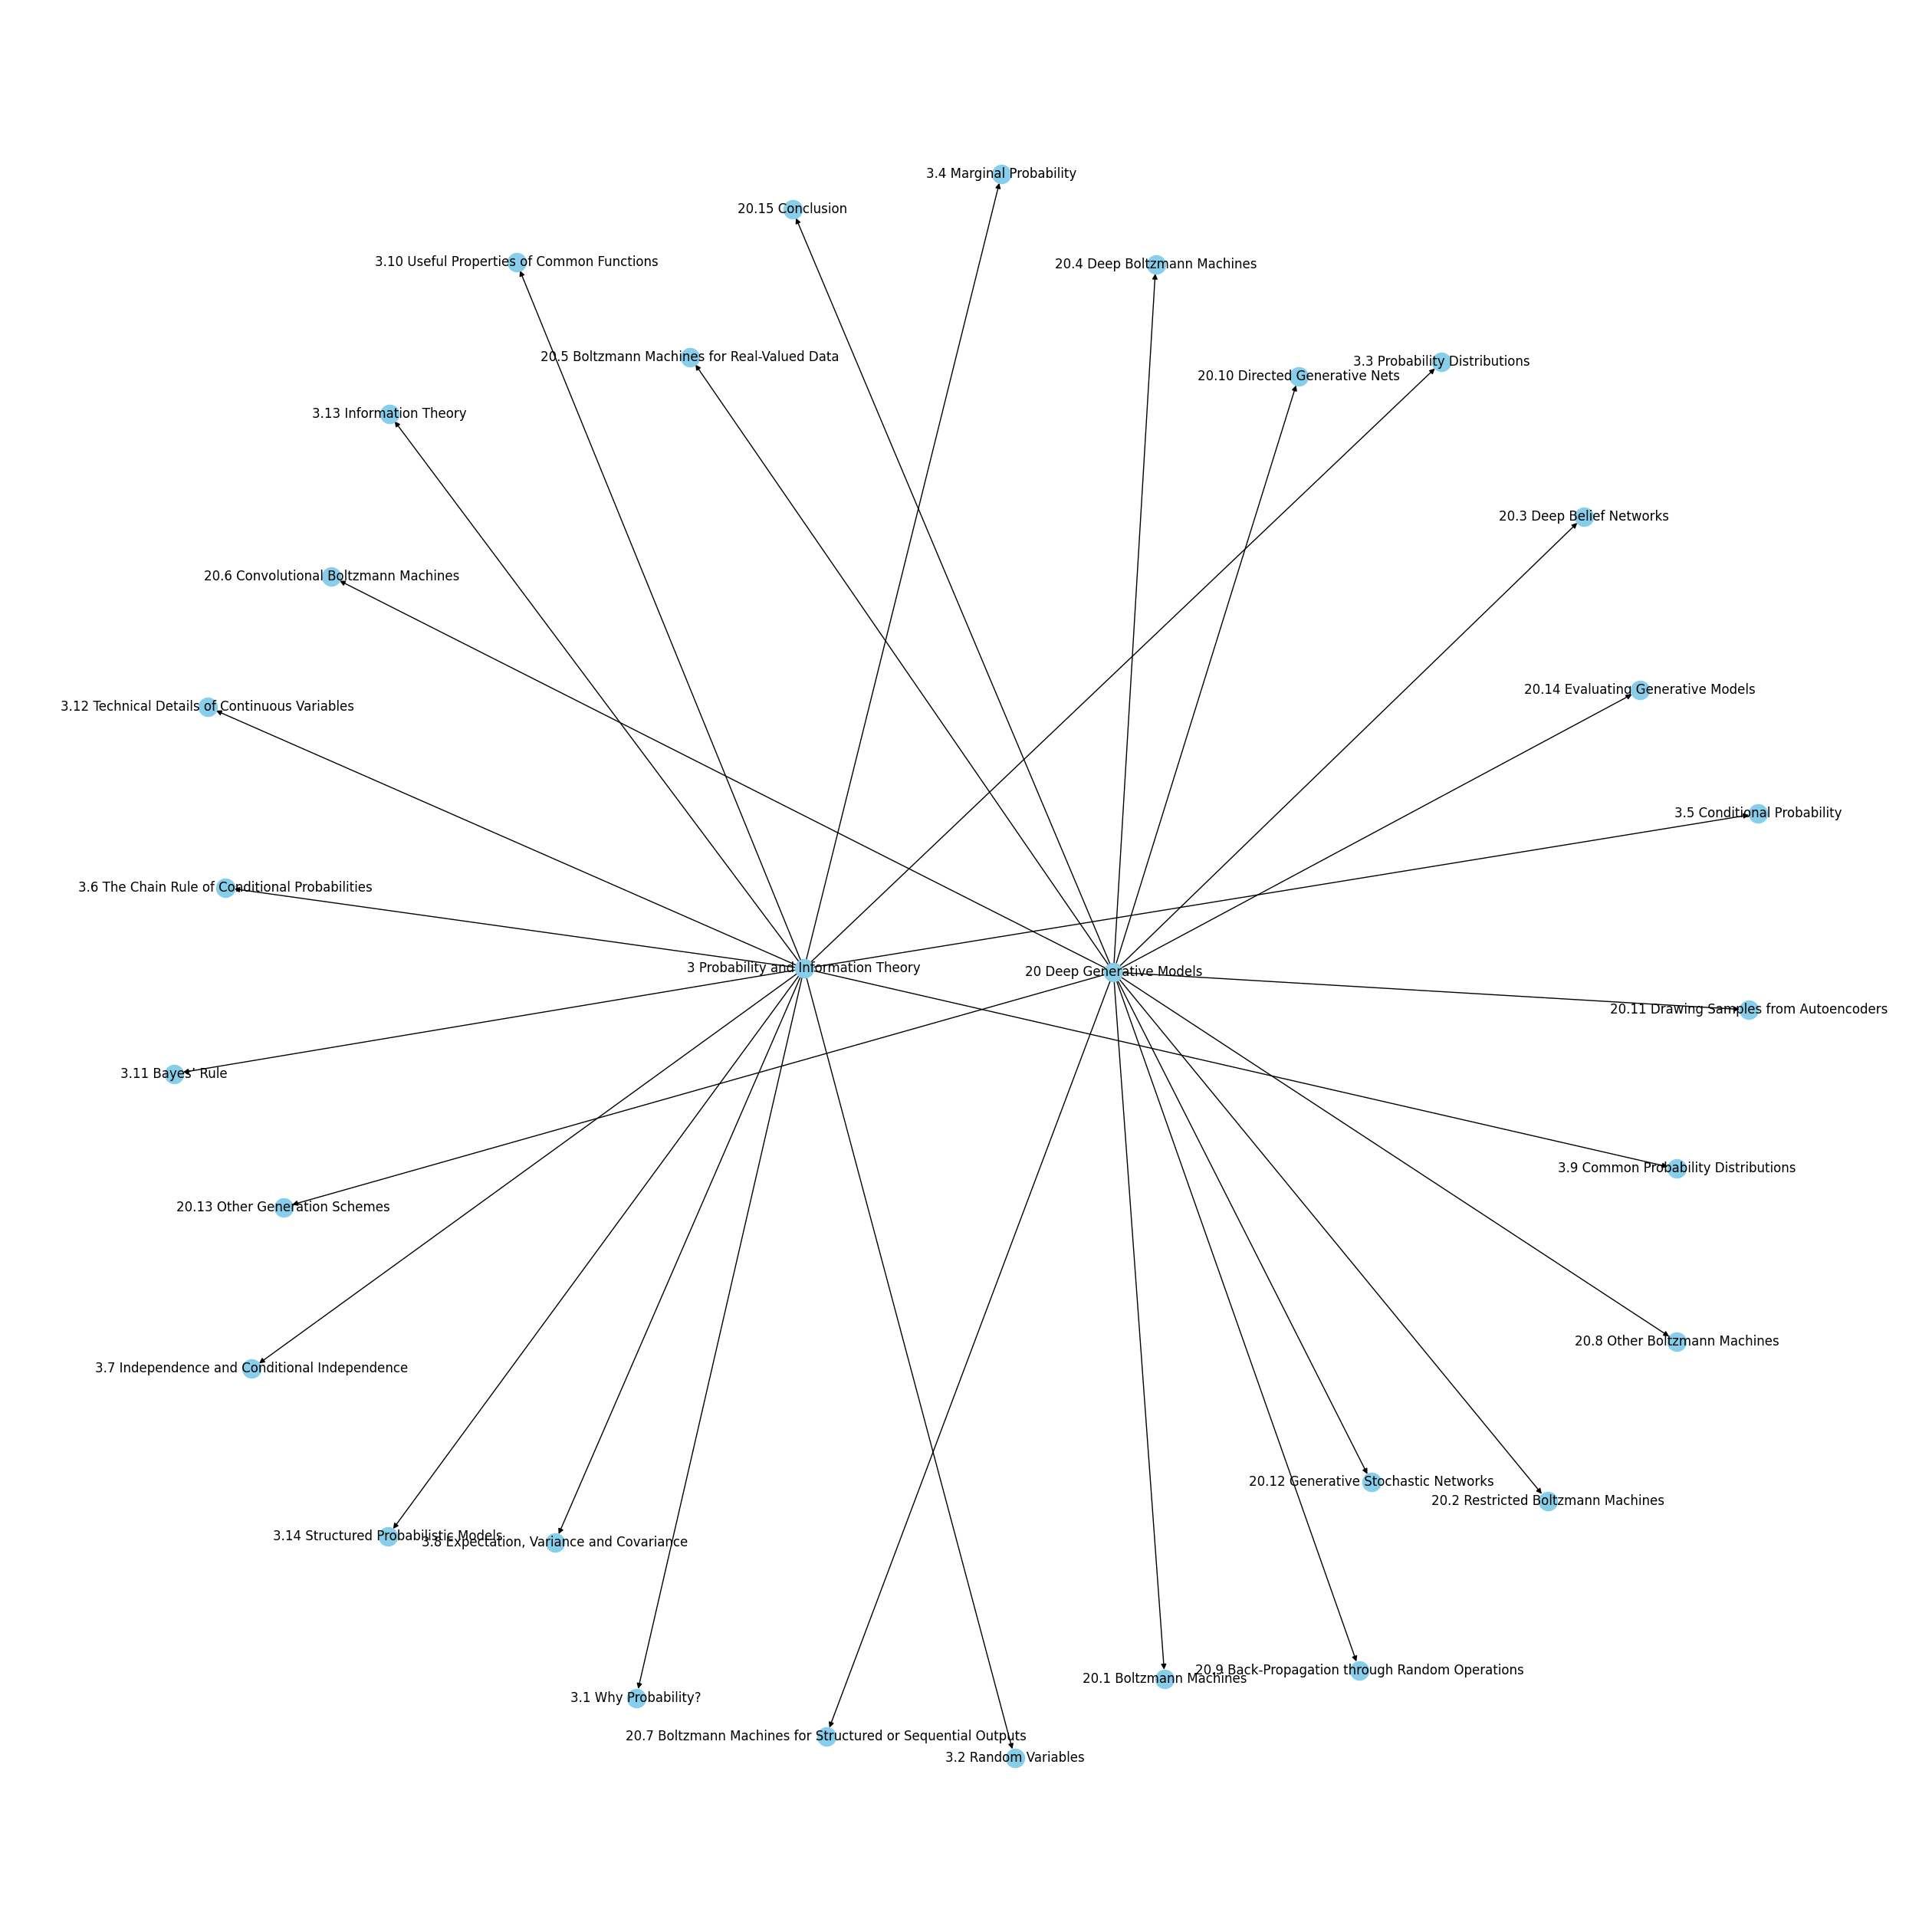

In [276]:
plt.figure(figsize=(25, 25))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## 一些其他尝试

### 使用dslim抽取实体

In [383]:
tokenizer = AutoTokenizer.from_pretrained(
    "dslim/bert-base-NER", cache_dir="../../../NER/dslim"
)
model = AutoModelForTokenClassification.from_pretrained(
    "dslim/bert-base-NER", cache_dir="../../../NER/dslim"
)

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = content_dict["1.1"][0]

ner_results = nlp(example)
for i in ner_results:
    print(i['word'])

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AI
AI
AI
AI


### 使用Rebel抽取实体
点击查看[build_kg NoteBook](./build_kg.ipynb)

### 基于BERT文本特征计算余弦相似度
`machine`与`happy`的余弦相似度为`0.903`  
`happy`与`asdqwe`(无意义)的余弦相似度为`0.921`  
可以想象这种方法判断的实体相似度并不是特别可靠  
如果主观随意设置余弦相似度的阈值，很有可能会合并一些在深度学习领域语义并不相同的实体  
可能需要在原BERT的基础上进行一定程度的微调

In [385]:
model = transformers.AutoModel.from_pretrained(
    "numind/entity-recognition-general-sota-v1",
    output_hidden_states=True,
    cache_dir="../../../NER/numind",
)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "numind/entity-recognition-general-sota-v1", cache_dir="../../../NER/numind"
)

In [386]:
text = ["machine", "deep learning", "machine learning", "happy", "asdqwe"]

encoded_input = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
output = model(**encoded_input)

emb = torch.cat((output.hidden_states[-1], output.hidden_states[-7]), dim=2)

embedding = emb[:, 0, :]
sim_dict = {}
for idx, ent in enumerate(embedding):
    for i in range(idx + 1, len(embedding)):
        cos_sim = ent.dot(embedding[i]) / (
            math.sqrt(ent.dot(ent)) * math.sqrt(embedding[i].dot(embedding[i]))
        )
        sim_dict[(text[idx], text[i])] = cos_sim.item()
        print(f"{text[idx]}与{text[i]}的余弦相似度为: {cos_sim:.3f}")

machine与deep learning的余弦相似度为: 0.893
machine与machine learning的余弦相似度为: 0.891
machine与happy的余弦相似度为: 0.903
machine与asdqwe的余弦相似度为: 0.918
deep learning与machine learning的余弦相似度为: 0.969
deep learning与happy的余弦相似度为: 0.862
deep learning与asdqwe的余弦相似度为: 0.889
machine learning与happy的余弦相似度为: 0.833
machine learning与asdqwe的余弦相似度为: 0.859
happy与asdqwe的余弦相似度为: 0.921


### 基于one-hop邻居节点Jaccard相似度

In [61]:
relation_df = pd.DataFrame(semantic_set, columns=["head", "relation", "tail"])

In [62]:
J_dict = {}
epsilon = 1e-2
for idx, entityA in tqdm(enumerate(c_entity_set), total=len(c_entity_set)):
    temp_dfA = relation_df[
        (relation_df["head"] == entityA) | (relation_df["tail"] == entityA)
    ]
    setA = (
        set() if temp_dfA.empty else set(temp_dfA["head"]).union(set(temp_dfA["tail"]))
    )
    if setA:
        setA.remove(entityA)
    for i in range(idx + 1, len(c_entity_set)):
        entityB = list(c_entity_set)[i]
        temp_dfB = relation_df[
            (relation_df["head"] == entityB) | (relation_df["tail"] == entityB)
        ]
        setB = (
            set()
            if temp_dfB.empty
            else set(temp_dfB["head"]).union(set(temp_dfB["tail"]))
        )
        if setB:
            setB.remove(entityB)
        union_idx = len(setA.union(setB))
        intersection_idx = len(setA.intersection(setB))
        J_dict[(entityA, entityB)] = (intersection_idx) / (union_idx + epsilon)

  0%|          | 0/1969 [00:00<?, ?it/s]

In [65]:
sort_feq(J_dict)[:20]

[(('larger representations', 'research problem'), 0.9950248756218907),
 (('larger representations', 'generative factors'), 0.9950248756218907),
 (('larger representations', 'brute force solution'), 0.9950248756218907),
 (('research problem', 'generative factors'), 0.9950248756218907),
 (('research problem', 'brute force solution'), 0.9950248756218907),
 (('generative factors', 'brute force solution'), 0.9950248756218907),
 (('random values', 'initial values'), 0.9900990099009901),
 (('random values', 'minimum value'), 0.9900990099009901),
 (('random values', 'saturate'), 0.9900990099009901),
 (('random values', 'mean absolute error'), 0.9900990099009901),
 (('random values', 'exp function'), 0.9900990099009901),
 (('random values', 'real-time computation'), 0.9900990099009901),
 (('random values', 'output distribution'), 0.9900990099009901),
 (('random values', 'model distribution'), 0.9900990099009901),
 (('random values', 'logp'), 0.9900990099009901),
 (('random values', 'negative in

### 基于TransE嵌入向量计算余弦相似度

In [392]:
temp_list = []
for i in semantic_set:
    temp_list.append(list(i))

In [396]:
entities2id = {'<unk>':0}
relations2id = {'<unk>':0}

def dataloader(entity, relation, triple):
    for e in entity:
        entities2id[e] = len(entities2id)
    entity_res = list(entities2id.values())
    for r in relation:
        relations2id[r] = len(relations2id)
    relation_res = list(relations2id.values())
    for line in triple:
        h_ = entities2id.get(line[0], 0)
        r_ = relations2id.get(line[1], 0)
        t_ = entities2id.get(line[2], 0)

        triple_list.append([h_, r_, t_])

    return entity_res, relation_res, triple_list

def norm_l1(h, r, t):
    return np.sum(np.fabs(h + r - t))


def norm_l2(h, r, t):
    return np.sum(np.square(h + r - t))


class TransE:
    def __init__(
        self,
        entity,
        relation,
        triple_list,
        embedding_dim=50,
        lr=0.01,
        margin=1.0,
        norm=1,
    ):
        self.entities = entity
        self.relations = relation
        self.triples = triple_list
        self.dimension = embedding_dim
        self.learning_rate = lr
        self.margin = margin
        self.norm = norm
        self.loss = 0.0

    def data_initialise(self):
        entityVectorList = {}
        relationVectorList = {}
        for entity in self.entities:
            entity_vector = np.random.uniform(
                -6.0 / np.sqrt(self.dimension),
                6.0 / np.sqrt(self.dimension),
                self.dimension,
            )
            entityVectorList[entity] = entity_vector

        for relation in self.relations:
            relation_vector = np.random.uniform(
                -6.0 / np.sqrt(self.dimension),
                6.0 / np.sqrt(self.dimension),
                self.dimension,
            )
            relation_vector = self.normalization(relation_vector)
            relationVectorList[relation] = relation_vector

        self.entities = entityVectorList
        self.relations = relationVectorList

    def normalization(self, vector):
        return vector / np.linalg.norm(vector)

    def training_run(self, epochs=1, nbatches=100, out_file_title=""):
        batch_size = int(len(self.triples) / nbatches)
        print("batch size: ", batch_size)
        for epoch in range(epochs):
            start = time.time()
            self.loss = 0.0
            # Normalise the embedding of the entities to 1
            for entity in self.entities.keys():
                self.entities[entity] = self.normalization(self.entities[entity])

            for batch in range(nbatches):
                batch_samples = random.sample(self.triples, batch_size)

                Tbatch = []
                for sample in batch_samples:
                    corrupted_sample = copy.deepcopy(sample)
                    pr = np.random.random(1)[0]
                    if pr > 0.5:
                        # change the head entity
                        corrupted_sample[0] = random.sample(self.entities.keys(), 1)[0]
                        while corrupted_sample[0] == sample[0]:
                            corrupted_sample[0] = random.sample(
                                self.entities.keys(), 1
                            )[0]
                    else:
                        # change the tail entity
                        corrupted_sample[2] = random.sample(self.entities.keys(), 1)[0]
                        while corrupted_sample[2] == sample[2]:
                            corrupted_sample[2] = random.sample(
                                self.entities.keys(), 1
                            )[0]

                    if (sample, corrupted_sample) not in Tbatch:
                        Tbatch.append((sample, corrupted_sample))

                self.update_triple_embedding(Tbatch)
            end = time.time()
            print("epoch: ", epoch, "cost time: %s" % (round((end - start), 3)))
            print("running loss: ", self.loss)

        with codecs.open(
            out_file_title
            + "TransE_entity_"
            + str(self.dimension)
            + "dim_batch"
            + str(batch_size),
            "w",
        ) as f1:
            for e in self.entities.keys():
                # f1.write("\t")
                # f1.write(e + "\t")
                f1.write(str(list(self.entities[e])))
                f1.write("\n")

        with codecs.open(
            out_file_title
            + "TransE_relation_"
            + str(self.dimension)
            + "dim_batch"
            + str(batch_size),
            "w",
        ) as f2:
            for r in self.relations.keys():
                # f2.write("\t")
                # f2.write(r + "\t")
                f2.write(str(list(self.relations[r])))
                f2.write("\n")

    def update_triple_embedding(self, Tbatch):
        # deepcopy 可以保证，即使list嵌套list也能让各层的地址不同， 即这里copy_entity 和
        # entitles中所有的elements都不同
        copy_entity = copy.deepcopy(self.entities)
        copy_relation = copy.deepcopy(self.relations)

        for correct_sample, corrupted_sample in Tbatch:
            correct_copy_head = copy_entity[correct_sample[0]]
            correct_copy_tail = copy_entity[correct_sample[2]]
            relation_copy = copy_relation[correct_sample[1]]

            corrupted_copy_head = copy_entity[corrupted_sample[0]]
            corrupted_copy_tail = copy_entity[corrupted_sample[2]]

            correct_head = self.entities[correct_sample[0]]
            correct_tail = self.entities[correct_sample[2]]
            relation = self.relations[correct_sample[1]]

            corrupted_head = self.entities[corrupted_sample[0]]
            corrupted_tail = self.entities[corrupted_sample[2]]

            # calculate the distance of the triples
            if self.norm == 1:
                correct_distance = norm_l1(correct_head, relation, correct_tail)
                corrupted_distance = norm_l1(corrupted_head, relation, corrupted_tail)

            else:
                correct_distance = norm_l2(correct_head, relation, correct_tail)
                corrupted_distance = norm_l2(corrupted_head, relation, corrupted_tail)

            loss = self.margin + correct_distance - corrupted_distance

            if loss > 0:
                self.loss += loss
                print(loss)
                correct_gradient = 2 * (correct_head + relation - correct_tail)
                corrupted_gradient = 2 * (corrupted_head + relation - corrupted_tail)

                if self.norm == 1:
                    for i in range(len(correct_gradient)):
                        if correct_gradient[i] > 0:
                            correct_gradient[i] = 1
                        else:
                            correct_gradient[i] = -1

                        if corrupted_gradient[i] > 0:
                            corrupted_gradient[i] = 1
                        else:
                            corrupted_gradient[i] = -1

                correct_copy_head -= self.learning_rate * correct_gradient
                relation_copy -= self.learning_rate * correct_gradient
                correct_copy_tail -= -1 * self.learning_rate * correct_gradient

                relation_copy -= -1 * self.learning_rate * corrupted_gradient
                if correct_sample[0] == corrupted_sample[0]:
                    # if corrupted_triples replaces the tail entity, the head entity's embedding need to be updated twice
                    correct_copy_head -= -1 * self.learning_rate * corrupted_gradient
                    corrupted_copy_tail -= self.learning_rate * corrupted_gradient
                elif correct_sample[2] == corrupted_sample[2]:
                    # if corrupted_triples replaces the head entity, the tail entity's embedding need to be updated twice
                    corrupted_copy_head -= -1 * self.learning_rate * corrupted_gradient
                    correct_copy_tail -= self.learning_rate * corrupted_gradient

                # normalising these new embedding vector, instead of normalising all the embedding together
                copy_entity[correct_sample[0]] = self.normalization(correct_copy_head)
                copy_entity[correct_sample[2]] = self.normalization(correct_copy_tail)
                if correct_sample[0] == corrupted_sample[0]:
                    # if corrupted_triples replace the tail entity, update the tail entity's embedding
                    copy_entity[corrupted_sample[2]] = self.normalization(
                        corrupted_copy_tail
                    )
                elif correct_sample[2] == corrupted_sample[2]:
                    # if corrupted_triples replace the head entity, update the head entity's embedding
                    copy_entity[corrupted_sample[0]] = self.normalization(
                        corrupted_copy_head
                    )
                # the paper mention that the relation's embedding don't need to be normalised
                copy_relation[correct_sample[1]] = relation_copy
                # copy_relation[correct_sample[1]] = self.normalization(relation_copy)

        self.entities = copy_entity
        self.relations = copy_relation


entity_set, relation_set, triple_list = dataloader(list(c_entity_set), list(relations_set), temp_list)

transE = TransE(
    entity_set, relation_set, triple_list, embedding_dim=30, lr=0.01, margin=1.0, norm=2
)
transE.data_initialise()
transE.training_run(out_file_title="umls_")

MemoryError: 